## Keras example for CPOL

In [381]:
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation, Embedding, Flatten, Dropout, TimeDistributed, Reshape, Lambda
from tensorflow.keras.layers import LSTM, ConvLSTM2D, Conv2D, ZeroPadding2D
from tensorflow.contrib.data.python.ops import sliding
#from keras.optimizers import RMSprop, Adam, SGD
#from keras import backend as K
#from keras.utils import to_categorical, Sequence
#from keras.callbacks import ModelCheckpoint
#from keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
import pyart
import numpy as np
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import warnings
from paramiko.client import SSHClient
from datetime import datetime
import os
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
tfrecords_path = '/home/rjackson/tfrecords/'
my_shape = []
num_frames_in_past = 3

In [4]:
def _int64_feature(value):
    """Creates a tf.Train.Feature from an int64 value."""
    if value is None:
        value = []
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

def _float_feature(value):
    """Creates a tf.Train.Feature from a bytes value."""
    if value is None:
        value = []
    if isinstance(value, np.ndarray):
        value = value.reshape(-1)
        value = bytes(value)
    if not isinstance(value, list):
        value = [value]
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def create_tf_record(radar_list, scan_no, num_previous_frames=3, num_frames_future=1):
    # Get radar file from bebop
    if scan_no < num_previous_frames:
        print("Not enough frames in the past.")
        return 
    elif scan_no+num_frames_future > len(radar_list):
        print("Not enough frames in future!")
        return
    
    # First get previous frames
    Znorm_list = []    
    times = np.zeros(num_previous_frames, dtype=datetime)
    for i in range(num_previous_frames-1, -1, -1):
        grid = xr.open_dataset(radar_list[scan_no-i])
        try:
            Znorm_list.append(grid.Znorm.values)
        except:
            return
        print(grid.time.values)
        times[i] = grid.time.values
        grid.close()
    Znorm = np.stack(Znorm_list)
    dt = np.diff(times)
    dt = np.concatenate([np.array([0]), dt])
    # Then get the future frame
    grid = xr.open_dataset(radar_list[scan_no+num_frames_future])
    try:
        Znorm_future = grid.Znorm.values
        max_ref = np.nanmax(Znorm_future)
        Znorm_future = Znorm_future/np.nanmax(Znorm_future)
    except:
        return
    grid_time = grid.time.values
    grid.close()
    norm = Znorm/np.nanmax(Znorm)
    shp = norm.shape
    my_shape = shp
    width = shp[0]
    height = shp[1]
    dt_future = grid_time - times[-1]
    fname = tfrecords_path + radar_list[scan_no][-16:] + '.tfrecord'
    writer = tf.python_io.TFRecordWriter(fname)
    
    #norm = norm.SerializeToString()
    example = tf.train.Example(features=tf.train.Features(
                    feature={
                        'width': _int64_feature(width),
                        'height': _int64_feature(height),
                        'image_raw': _bytes_feature(Znorm),
                        'label': _bytes_feature(Znorm_future),
                        'num_frames_in_past': _int64_feature(num_previous_frames),
                        'num_frames_in_future': _int64_feature(num_frames_future),
                        'dt_past': _bytes_feature(dt),
                        'dt_future': _float_feature(dt_future),
                        'max_ref': _float_feature(max_ref)
                    }))
    writer.write(example.SerializeToString())

    del writer

In [ ]:
t1 = datetime(2006, 1, 1, 1, 0, 0)
t2 = datetime(2009, 1, 1, 9, 0, 1)
(t2-t1).seconds

In [ ]:
my_path = '/home/rjackson/radar_images/2005**/*.cdf'
radar_list = glob(my_path, recursive=True)
#radar_list = radar_list + glob('/home/rjackson/data/radar/gridded_data/20060121/*1000m*.nc', recursive=True)
radar_list = sorted(radar_list)
print(len(radar_list))
grid = xr.open_dataset(radar_list[0])
Znorm = grid.Znorm.values
grid_time = grid.time.values
grid.close()
norm = Znorm/np.nanmax(Znorm)


In [8]:
my_shape = (201, 201)
print(my_shape)

(201, 201)


In [7]:
for i in range(len(radar_list)):
    create_tf_record(radar_list, i)
    i = i + 1
    if i % 100 == 0:
        print(i)

Not enough frames in the past.
Not enough frames in the past.
Not enough frames in the past.
2005-01-06T05:30:08.000000000
2005-01-06T05:40:09.000000000
2005-01-06T05:50:09.000000000
2005-01-06T05:40:09.000000000
2005-01-06T05:50:09.000000000
2005-01-06T06:00:09.000000000
2005-01-06T05:50:09.000000000
2005-01-06T06:00:09.000000000
2005-01-06T06:10:14.000000000
2005-01-06T06:00:09.000000000
2005-01-06T06:10:14.000000000
2005-01-06T06:20:09.000000000
2005-01-06T06:10:14.000000000
2005-01-06T06:20:09.000000000
2005-01-06T06:30:09.000000000
2005-01-06T06:20:09.000000000
2005-01-06T06:30:09.000000000
2005-01-06T06:40:08.000000000
2005-01-06T06:30:09.000000000
2005-01-06T06:40:08.000000000
2005-01-06T06:50:08.000000000
2005-01-06T06:40:08.000000000
2005-01-06T06:50:08.000000000
2005-01-06T07:00:08.000000000
2005-01-06T06:50:08.000000000
2005-01-06T07:00:08.000000000
2005-01-06T07:10:15.000000000
2005-01-06T07:00:08.000000000
2005-01-06T07:10:15.000000000
2005-01-06T07:20:08.000000000
2005-01

2005-01-06T20:50:08.000000000
2005-01-06T21:00:08.000000000
2005-01-06T21:10:15.000000000
2005-01-06T21:00:08.000000000
2005-01-06T21:10:15.000000000
2005-01-06T21:20:09.000000000
2005-01-06T21:10:15.000000000
2005-01-06T21:20:09.000000000
2005-01-06T21:30:09.000000000
2005-01-06T21:20:09.000000000
2005-01-06T21:30:09.000000000
2005-01-06T21:40:09.000000000
2005-01-06T21:30:09.000000000
2005-01-06T21:40:09.000000000
2005-01-06T21:50:09.000000000
2005-01-06T21:40:09.000000000
2005-01-06T21:50:09.000000000
2005-01-06T22:00:09.000000000
100
2005-01-06T21:50:09.000000000
2005-01-06T22:00:09.000000000
2005-01-06T22:10:16.000000000
2005-01-06T22:00:09.000000000
2005-01-06T22:10:16.000000000
2005-01-06T22:20:08.000000000
2005-01-06T22:10:16.000000000
2005-01-06T22:20:08.000000000
2005-01-06T22:30:08.000000000
2005-01-06T22:20:08.000000000
2005-01-06T22:30:08.000000000
2005-01-06T22:40:08.000000000
2005-01-06T22:30:08.000000000
2005-01-06T22:40:08.000000000
2005-01-06T22:50:08.000000000
2005-0

2005-12-21T12:30:09.000000000
2005-12-21T12:40:09.000000000
2005-12-21T12:50:09.000000000
2005-12-21T12:40:09.000000000
2005-12-21T12:50:09.000000000
2005-12-21T13:00:09.000000000
2005-12-21T12:50:09.000000000
2005-12-21T13:00:09.000000000
2005-12-21T13:10:11.000000000
2005-12-21T13:00:09.000000000
2005-12-21T13:10:11.000000000
2005-12-21T13:20:08.000000000
2005-12-21T13:10:11.000000000
2005-12-21T13:20:08.000000000
2005-12-21T13:30:08.000000000
2005-12-21T13:20:08.000000000
2005-12-21T13:30:08.000000000
2005-12-21T13:40:09.000000000
2005-12-21T13:30:08.000000000
2005-12-21T13:40:09.000000000
2005-12-21T13:50:09.000000000
2005-12-21T13:40:09.000000000
2005-12-21T13:50:09.000000000
2005-12-21T14:00:09.000000000
2005-12-21T13:50:09.000000000
2005-12-21T14:00:09.000000000
2005-12-21T14:10:11.000000000
2005-12-21T14:00:09.000000000
2005-12-21T14:10:11.000000000
2005-12-21T14:20:09.000000000
2005-12-21T14:10:11.000000000
2005-12-21T14:20:09.000000000
2005-12-21T14:30:09.000000000
2005-12-21

2005-12-22T03:40:08.000000000
2005-12-22T03:50:08.000000000
2005-12-22T04:00:09.000000000
2005-12-22T03:50:08.000000000
2005-12-22T04:00:09.000000000
2005-12-22T04:10:12.000000000
2005-12-22T04:00:09.000000000
2005-12-22T04:10:12.000000000
2005-12-22T04:20:09.000000000
2005-12-22T04:10:12.000000000
2005-12-22T04:20:09.000000000
2005-12-22T04:30:09.000000000
2005-12-22T04:20:09.000000000
2005-12-22T04:30:09.000000000
2005-12-22T04:40:09.000000000
2005-12-22T04:30:09.000000000
2005-12-22T04:40:09.000000000
2005-12-22T04:50:09.000000000
2005-12-22T04:40:09.000000000
2005-12-22T04:50:09.000000000
2005-12-22T05:00:09.000000000
2005-12-22T04:50:09.000000000
2005-12-22T05:00:09.000000000
2005-12-22T05:10:12.000000000
2005-12-22T05:00:09.000000000
2005-12-22T05:10:12.000000000
2005-12-22T05:20:09.000000000
2005-12-22T05:10:12.000000000
2005-12-22T05:20:09.000000000
2005-12-22T05:30:08.000000000
2005-12-22T05:20:09.000000000
2005-12-22T05:30:08.000000000
2005-12-22T05:40:08.000000000
2005-12-22

2005-12-22T19:00:09.000000000
2005-12-22T19:10:12.000000000
2005-12-22T19:20:09.000000000
2005-12-22T19:10:12.000000000
2005-12-22T19:20:09.000000000
2005-12-22T19:30:09.000000000
2005-12-22T19:20:09.000000000
2005-12-22T19:30:09.000000000
2005-12-22T19:40:08.000000000
2005-12-22T19:30:09.000000000
2005-12-22T19:40:08.000000000
2005-12-22T19:50:08.000000000
2005-12-22T19:40:08.000000000
2005-12-22T19:50:08.000000000
2005-12-22T20:00:08.000000000
2005-12-22T19:50:08.000000000
2005-12-22T20:00:08.000000000
2005-12-22T20:10:11.000000000
2005-12-22T20:00:08.000000000
2005-12-22T20:10:11.000000000
2005-12-22T20:20:09.000000000
2005-12-22T20:10:11.000000000
2005-12-22T20:20:09.000000000
2005-12-22T20:30:09.000000000
2005-12-22T20:20:09.000000000
2005-12-22T20:30:09.000000000
2005-12-22T20:40:09.000000000
2005-12-22T20:30:09.000000000
2005-12-22T20:40:09.000000000
2005-12-22T20:50:09.000000000
2005-12-22T20:40:09.000000000
2005-12-22T20:50:09.000000000
2005-12-22T21:00:09.000000000
2005-12-22

2005-12-23T10:20:09.000000000
2005-12-23T10:30:09.000000000
2005-12-23T10:40:09.000000000
2005-12-23T10:30:09.000000000
2005-12-23T10:40:09.000000000
2005-12-23T10:50:08.000000000
2005-12-23T10:40:09.000000000
2005-12-23T10:50:08.000000000
2005-12-23T11:00:08.000000000
2005-12-23T10:50:08.000000000
2005-12-23T11:00:08.000000000
2005-12-23T11:10:11.000000000
2005-12-23T11:00:08.000000000
2005-12-23T11:10:11.000000000
2005-12-23T11:20:08.000000000
2005-12-23T11:10:11.000000000
2005-12-23T11:20:08.000000000
2005-12-23T11:30:09.000000000
2005-12-23T11:20:08.000000000
2005-12-23T11:30:09.000000000
2005-12-23T11:40:09.000000000
2005-12-23T11:30:09.000000000
2005-12-23T11:40:09.000000000
2005-12-23T11:50:09.000000000
2005-12-23T11:40:09.000000000
2005-12-23T11:50:09.000000000
2005-12-23T12:00:09.000000000
2005-12-23T11:50:09.000000000
2005-12-23T12:00:09.000000000
2005-12-23T12:10:11.000000000
2005-12-23T12:00:09.000000000
2005-12-23T12:10:11.000000000
2005-12-23T12:20:09.000000000
2005-12-23

2005-12-24T01:40:08.000000000
2005-12-24T01:50:09.000000000
2005-12-24T01:40:08.000000000
2005-12-24T01:50:09.000000000
2005-12-24T02:00:09.000000000
2005-12-24T01:50:09.000000000
2005-12-24T02:00:09.000000000
2005-12-24T02:10:11.000000000
2005-12-24T02:00:09.000000000
2005-12-24T02:10:11.000000000
2005-12-24T02:20:09.000000000
2005-12-24T02:10:11.000000000
2005-12-24T02:20:09.000000000
2005-12-24T02:30:09.000000000
2005-12-24T02:20:09.000000000
2005-12-24T02:30:09.000000000
2005-12-24T02:40:09.000000000
2005-12-24T02:30:09.000000000
2005-12-24T02:40:09.000000000
2005-12-24T02:50:09.000000000
2005-12-24T02:40:09.000000000
2005-12-24T02:50:09.000000000
2005-12-24T03:00:09.000000000
2005-12-24T02:50:09.000000000
2005-12-24T03:00:09.000000000
2005-12-24T03:10:10.000000000
2005-12-24T03:00:09.000000000
2005-12-24T03:10:10.000000000
2005-12-24T03:20:08.000000000
2005-12-24T03:10:10.000000000
2005-12-24T03:20:08.000000000
2005-12-24T03:30:08.000000000
2005-12-24T03:20:08.000000000
2005-12-24

2005-12-24T16:50:08.000000000
2005-12-24T17:00:08.000000000
2005-12-24T17:10:11.000000000
2005-12-24T17:00:08.000000000
2005-12-24T17:10:11.000000000
2005-12-24T17:20:09.000000000
2005-12-24T17:10:11.000000000
2005-12-24T17:20:09.000000000
2005-12-24T17:30:09.000000000
2005-12-24T17:20:09.000000000
2005-12-24T17:30:09.000000000
2005-12-24T17:40:09.000000000
2005-12-24T17:30:09.000000000
2005-12-24T17:40:09.000000000
2005-12-24T17:50:09.000000000
2005-12-24T17:40:09.000000000
2005-12-24T17:50:09.000000000
2005-12-24T18:00:09.000000000
2005-12-24T17:50:09.000000000
2005-12-24T18:00:09.000000000
2005-12-24T18:10:11.000000000
2005-12-24T18:00:09.000000000
2005-12-24T18:10:11.000000000
2005-12-24T18:20:09.000000000
2005-12-24T18:10:11.000000000
2005-12-24T18:20:09.000000000
2005-12-24T18:30:09.000000000
2005-12-24T18:20:09.000000000
2005-12-24T18:30:09.000000000
2005-12-24T18:40:09.000000000
2005-12-24T18:30:09.000000000
2005-12-24T18:40:09.000000000
2005-12-24T18:50:09.000000000
2005-12-24

2005-12-25T08:10:11.000000000
2005-12-25T08:20:08.000000000
2005-12-25T08:30:09.000000000
2005-12-25T08:20:08.000000000
2005-12-25T08:30:09.000000000
2005-12-25T08:40:09.000000000
2005-12-25T08:30:09.000000000
2005-12-25T08:40:09.000000000
2005-12-25T08:50:09.000000000
2005-12-25T08:40:09.000000000
2005-12-25T08:50:09.000000000
2005-12-25T09:00:09.000000000
2005-12-25T08:50:09.000000000
2005-12-25T09:00:09.000000000
2005-12-25T09:10:11.000000000
2005-12-25T09:00:09.000000000
2005-12-25T09:10:11.000000000
2005-12-25T09:20:08.000000000
2005-12-25T09:10:11.000000000
2005-12-25T09:20:08.000000000
2005-12-25T09:30:09.000000000
2005-12-25T09:20:08.000000000
2005-12-25T09:30:09.000000000
2005-12-25T09:40:09.000000000
2005-12-25T09:30:09.000000000
2005-12-25T09:40:09.000000000
2005-12-25T09:50:09.000000000
2005-12-25T09:40:09.000000000
2005-12-25T09:50:09.000000000
2005-12-25T10:00:09.000000000
2005-12-25T09:50:09.000000000
2005-12-25T10:00:09.000000000
2005-12-25T10:10:11.000000000
2005-12-25

2005-12-25T23:50:13.000000000
2005-12-26T00:00:09.000000000
2005-12-25T23:50:13.000000000
2005-12-26T00:00:09.000000000
2005-12-26T00:10:14.000000000
2005-12-26T00:00:09.000000000
2005-12-26T00:10:14.000000000
2005-12-26T00:20:08.000000000
2005-12-26T00:10:14.000000000
2005-12-26T00:20:08.000000000
2005-12-26T00:30:08.000000000
2005-12-26T00:20:08.000000000
2005-12-26T00:30:08.000000000
2005-12-26T00:40:08.000000000
2005-12-26T00:30:08.000000000
2005-12-26T00:40:08.000000000
2005-12-26T00:50:09.000000000
2005-12-26T00:40:08.000000000
2005-12-26T00:50:09.000000000
2005-12-26T01:00:09.000000000
2005-12-26T00:50:09.000000000
2005-12-26T01:00:09.000000000
2005-12-26T01:10:12.000000000
2005-12-26T01:00:09.000000000
2005-12-26T01:10:12.000000000
2005-12-26T01:20:09.000000000
2005-12-26T01:10:12.000000000
2005-12-26T01:20:09.000000000
2005-12-26T01:30:09.000000000
2005-12-26T01:20:09.000000000
2005-12-26T01:30:09.000000000
2005-12-26T01:40:09.000000000
2005-12-26T01:30:09.000000000
2005-12-26

2005-12-26T15:10:11.000000000
2005-12-26T15:20:08.000000000
2005-12-26T15:30:08.000000000
2005-12-26T15:20:08.000000000
2005-12-26T15:30:08.000000000
2005-12-26T15:40:13.000000000
2005-12-26T15:30:08.000000000
2005-12-26T15:40:13.000000000
2005-12-26T15:50:09.000000000
2005-12-26T15:40:13.000000000
2005-12-26T15:50:09.000000000
2005-12-26T16:00:09.000000000
2005-12-26T15:50:09.000000000
2005-12-26T16:00:09.000000000
2005-12-26T16:10:12.000000000
2005-12-26T16:00:09.000000000
2005-12-26T16:10:12.000000000
2005-12-26T16:20:08.000000000
2005-12-26T16:10:12.000000000
2005-12-26T16:20:08.000000000
2005-12-26T16:30:08.000000000
2005-12-26T16:20:08.000000000
2005-12-26T16:30:08.000000000
2005-12-26T16:40:09.000000000
2005-12-26T16:30:08.000000000
2005-12-26T16:40:09.000000000
2005-12-26T16:50:09.000000000
2005-12-26T16:40:09.000000000
2005-12-26T16:50:09.000000000
2005-12-26T17:00:09.000000000
2005-12-26T16:50:09.000000000
2005-12-26T17:00:09.000000000
2005-12-26T17:10:12.000000000
2005-12-26

2005-12-27T06:40:09.000000000
2005-12-27T06:30:09.000000000
2005-12-27T06:40:09.000000000
2005-12-27T06:50:09.000000000
2005-12-27T06:40:09.000000000
2005-12-27T06:50:09.000000000
2005-12-27T07:00:09.000000000
2005-12-27T06:50:09.000000000
2005-12-27T07:00:09.000000000
2005-12-27T07:10:12.000000000
2005-12-27T07:00:09.000000000
2005-12-27T07:10:12.000000000
2005-12-27T07:20:09.000000000
2005-12-27T07:10:12.000000000
2005-12-27T07:20:09.000000000
2005-12-27T07:30:09.000000000
2005-12-27T07:20:09.000000000
2005-12-27T07:30:09.000000000
2005-12-27T07:40:09.000000000
2005-12-27T07:30:09.000000000
2005-12-27T07:40:09.000000000
2005-12-27T07:50:09.000000000
2005-12-27T07:40:09.000000000
2005-12-27T07:50:09.000000000
2005-12-27T08:00:09.000000000
2005-12-27T07:50:09.000000000
2005-12-27T08:00:09.000000000
2005-12-27T08:10:12.000000000
2005-12-27T08:00:09.000000000
2005-12-27T08:10:12.000000000
2005-12-27T08:20:08.000000000
2005-12-27T08:10:12.000000000
2005-12-27T08:20:08.000000000
2005-12-27

2005-12-27T22:10:13.000000000
2005-12-27T22:20:09.000000000
2005-12-27T22:10:13.000000000
2005-12-27T22:20:09.000000000
2005-12-27T22:30:09.000000000
2005-12-27T22:20:09.000000000
2005-12-27T22:30:09.000000000
2005-12-27T22:40:09.000000000
2005-12-27T22:30:09.000000000
2005-12-27T22:40:09.000000000
2005-12-27T22:50:08.000000000
2005-12-27T22:40:09.000000000
2005-12-27T22:50:08.000000000
2005-12-27T23:00:08.000000000
2005-12-27T22:50:08.000000000
2005-12-27T23:00:08.000000000
2005-12-27T23:10:13.000000000
2005-12-27T23:00:08.000000000
2005-12-27T23:10:13.000000000
2005-12-27T23:20:13.000000000
2005-12-27T23:10:13.000000000
2005-12-27T23:20:13.000000000
2005-12-27T23:30:09.000000000
2005-12-27T23:20:13.000000000
2005-12-27T23:30:09.000000000
2005-12-27T23:40:09.000000000
2005-12-27T23:30:09.000000000
2005-12-27T23:40:09.000000000
2005-12-27T23:50:09.000000000


IndexError: list index out of range

In [6]:
first_greyscale_field = get_greyscale_field(radar_list[99])
print(first_greyscale_field)
first_greyscale_field.shape

None


AttributeError: 'NoneType' object has no attribute 'shape'

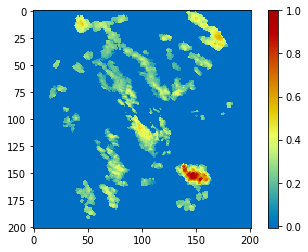

In [26]:
plt.imshow(first_greyscale_field, cmap='pyart_HomeyerRainbow')
plt.colorbar()

In [269]:
# Load TFRecordDataset
file_pattern_training = '/home/rjackson/tfrecords/2006/*'
is_training = True
shuffle = False
frames_in_past = 3
frames_in_future = 1

def parse_record(record):
    feature={'width': tf.FixedLenFeature([], tf.int64, default_value=0),
             'height': tf.FixedLenFeature([], tf.int64, default_value=0),
             'image_raw': tf.FixedLenFeature([], tf.string, default_value=""),
             'time': tf.FixedLenFeature([], tf.float32, default_value=0.),
            }
    features = tf.io.parse_single_example(record, feature)
    image_shape = (my_shape[0], my_shape[1], 1) 
    features['image_raw'] = tf.decode_raw(features['image_raw'], tf.float32)
    features['image_raw'] = tf.reshape(features['image_raw'], shape=image_shape)
    return {'image_raw': features['image_raw']}

#my_dataset = tf.data.TFRecordDataset(my_files)
def input_fn():

    file_list = glob(file_pattern_training)
    filelist = tf.data.TFRecordDataset(file_list)

    if is_training:
        if shuffle:
            dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(
                      buffer_size=shuffle_buffer, seed=seed))
        else:
            dataset = dataset.repeat()

    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.apply(
            tf.data.experimental.map_and_batch(
                parse_record,
                batch_size=30,
                num_parallel_batches=4,
                drop_remainder=True)) 
    return dataset

#{'conv_lst_m2d_input':features['image_raw']}, {'conv2d':features['label']}
def make_inputs(record):
    return {'conv_lst_m2d_input': record}

def make_labels(record):
    return {'conv2d': record}

In [337]:
file_list = sorted(glob(file_pattern_training))
filelist = tf.data.TFRecordDataset(file_list)

parsed_data = filelist.map(parse_record)
parsed_data = parsed_data.repeat()
parsed_data = parsed_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def my_func(x):
    return x["image_raw"].batch(4)

features = parsed_data.window(4, 1)
print(features)
features = features.flat_map(my_func)
features = features.apply(tf.data.experimental.map_and_batch(make_inputs, 30))
labels = parsed_data.skip(1)
labels = labels.map(lambda x: x["image_raw"])
labels = labels.apply(tf.data.experimental.map_and_batch(make_labels, 30))
new_ds = tf.data.Dataset.zip((features, labels))
print(new_ds)

<DatasetV1Adapter shapes: {image_raw: <tensorflow.python.data.ops.dataset_ops.DatasetStructure object at 0x7f272b580748>}, types: {image_raw: <tensorflow.python.data.ops.dataset_ops.DatasetStructure object at 0x7f272b580748>}>
<DatasetV1Adapter shapes: ({conv_lst_m2d_input: (?, ?, 201, 201, 1)}, {conv2d: (?, 201, 201, 1)}), types: ({conv_lst_m2d_input: tf.float32}, {conv2d: tf.float32})>


(2, 30, 4, 201, 201, 1)


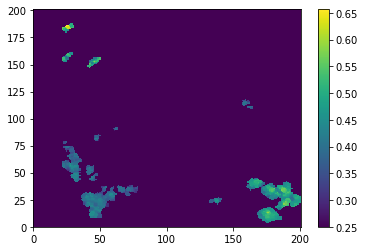

In [358]:
label = features.take(2)
array = np.stack([x['conv_lst_m2d_input'].numpy() for x in label])
print(array.shape)
plt.pcolormesh(array[0, 3, 3, :, :, 0])
plt.colorbar()

(2, 30, 201, 201, 1)


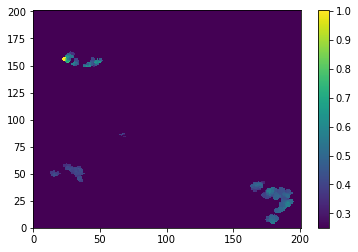

In [357]:
label = labels.take(2)
array = np.stack([x["conv2d"].numpy() for x in label])
print(array.shape)
plt.pcolormesh(array[0, 3, :, :, 0])
plt.colorbar()

In [204]:
my_ds = [x for x in tf.data.Dataset.range(7).window(1, shift=1).take(3)]
for x in my_ds:
    print(x)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


In [4]:
hidden_size = 5
use_dropout=True
num_steps = 3
my_shape = (201, 201)
print(my_shape)
the_shape = my_shape
def model_function():
    new_shape = (num_steps, the_shape[0], the_shape[1], 1)
    #new_shape_conv10 = (num_steps, the_shape[0]-conv_window, the_shape[1]-conv_window, 1)

    model = Sequential()
    model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
        input_shape=new_shape, data_format='channels_last', return_sequences=True,
        padding='same', activation='relu'))
    model.add(ConvLSTM2D(filters=1, kernel_size=(9, 9),
        data_format='channels_last', return_sequences=True,
        padding='same', activation='relu'))
    model.add(ConvLSTM2D(filters=1, kernel_size=(9, 9),
        data_format='channels_last', return_sequences=True,
        padding='same', activation='relu'))
    model.add(ConvLSTM2D(filters=1, kernel_size=(3, 3),
        data_format='channels_last', return_sequences=False,
        padding='same', activation='relu'))
    model.add(Conv2D(filters=1, kernel_size=(1, 1), padding='same',
                 data_format='channels_last', activation='relu'))
    #odel.add(ConvLSTM2D(1, 10, input_shape=new_shape_conv10, data_format='channels_last', return_sequences=True))
    #if use_dropout:
    #    model.add(Dropout(0.5))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

#my_model = model_function()
#my_estimator = tf.keras.estimator.model_to_estimator(keras_model=my_model)

(201, 201)


In [ ]:
my_estimator.train(input_fn=input_fn, steps=10)

In [103]:
y[8,:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

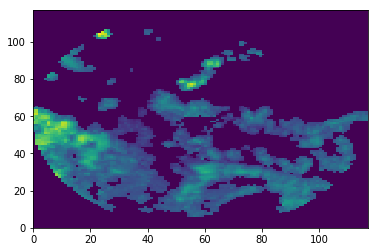

In [104]:
plt.pcolormesh(y[12,:,:,0])

In [8]:
plt.pcolormesh(x[0][0,1,:,:,0])

NameError: name 'x' is not defined

In [7]:
num_steps = 3
conv_window = 3
batch_size = 1
train_data_len = round(0.8*len(radar_list))
labels = {}
# Create labels for each member of radar dataset
for i in range(len(radar_list)):
    label_key = "id-" + str(i)
    labels[label_key] = i
    
training_data = DataGenerator([int(x) for x in range(0, train_data_len)], labels,
                              batch_size=30, n_classes=1)
validation_data = DataGenerator([int(x) for x in range(train_data_len, len(radar_list))], labels,
                                batch_size=30, n_classes=1)

In [38]:
hidden_size = 5
use_dropout=True
the_array = first_greyscale_field
new_shape = (num_steps, the_shape.shape[0], the_array.shape[1], 1)
new_shape_conv10 = (num_steps, the_array.shape[0]-conv_window, the_array.shape[1]-conv_window, 1)
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(9, 9),
                     input_shape=new_shape, data_format='channels_last', return_sequences=True,
                     padding='valid', activation='relu'))
model.add(ConvLSTM2D(filters=1, kernel_size=(conv_window, conv_window),
                     input_shape=new_shape, data_format='channels_last', return_sequences=False,
                     padding='valid', activation='relu'))

model.add(ZeroPadding2D(5))
#odel.add(ConvLSTM2D(1, 10, input_shape=new_shape_conv10, data_format='channels_last', return_sequences=True))
#if use_dropout:
#    model.add(Dropout(0.5))
model.compile(loss='mean_squared_error', optimizer='adam')

INFO (theano.gof.compilelock): Refreshing lock /blues/gpfs/home/rjackson/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.6.1810-Core-x86_64-3.7.3-64/lock_dir/lock


In [10]:
data_path = '/home/rjackson/deep_learning_fun'
checkpointer = ModelCheckpoint(filepath=data_path + '/3-layer-model-{epoch:02d}.hdf5', verbose=1)

In [ ]:
num_epochs = 30
model.fit_generator(training_data, None, epochs=10, callbacks=[checkpointer])

Epoch 1/10
118/118 [==============================] - 4516s 38s/step - loss: 0.0144

Epoch 00001: saving model to /home/rjackson/deep_learning_fun/2-layer-model-01.hdf5
Epoch 2/10
118/118 [==============================] - 4543s 39s/step - loss: 0.0134

Epoch 00002: saving model to /home/rjackson/deep_learning_fun/2-layer-model-02.hdf5
Epoch 3/10
 97/118 [=======================>......] - ETA: 13:22 - loss: 0.0125

In [59]:
my_model = model_function()
the_estimator = tf.keras.estimator.model_to_estimator(keras_model=my_model, model_dir='/home/rjackson/DNNmodel/')
the_estimator.train(input_fn=input_fn, steps=1000.)
#the_model.load_weights('/home/rjackson/DNNmodel/model.ckpt-100')

KeyError: "The dictionary passed into features does not have the expected inputs keys defined in the keras model.\n\tExpected keys: {'conv_lst_m2d_12_input'}\n\tfeatures keys: {'conv_lst_m2d_8_input'}\n\tDifference: {'conv_lst_m2d_12_input', 'conv_lst_m2d_8_input'}"

In [49]:
y_model = the_model.fit(input_fn(), steps_per_epoch=100)

ValueError: No data provided for "conv_lst_m2d_6_input". Need data for each key in: ['conv_lst_m2d_6_input']

10/10 [==============================] - 73s 7s/step - loss: 136.1508


136.15081043243407

In [14]:
y_model.shape

(300, 201, 201, 1)

## Validation - a week in December 2005. 

In [372]:
# Load TFRecordDataset
file_pattern = '/home/rjackson/tfrecords/2005/20051224*.tfrecord'
is_training = False
shuffle = False
num_frames_in_future = 6
num_frames_in_past = 3
#my_dataset = tf.data.TFRecordDataset(my_files)
my_shape = (201, 201)
def input_fn_validation(num_frames_in_future):
    def parse_record(record):
        feature={'width': tf.FixedLenFeature([], tf.int64, default_value=0),
                 'height': tf.FixedLenFeature([], tf.int64, default_value=0),
                 'image_raw': tf.FixedLenFeature([], tf.string, default_value=""),
                 'time': tf.FixedLenFeature([], tf.float32, default_value=0.),
                }
        features = tf.io.parse_single_example(record, feature)
        image_shape = (my_shape[0], my_shape[1], 1)
        features['image_raw'] = tf.decode_raw(features['image_raw'], tf.float32)
        features['image_raw'] = tf.reshape(features['image_raw'], shape=image_shape)
        return {'image_raw': features['image_raw']}

    def make_inputs(record):
        return {'conv_lst_m2d_input': record}

    def make_labels(record):
        return {'conv2d': record}

    file_list = sorted(glob(file_pattern))

    dataset = tf.data.TFRecordDataset(file_list)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_record)
    
    dataset = dataset.repeat()
    features = dataset.window(size=num_frames_in_past, shift=1)
    features = features.flat_map(lambda x: x["image_raw"].batch(num_frames_in_past))
    features = features.map(make_inputs)
    features = features.batch(30)
    labels = dataset.skip(num_frames_in_future)
    labels = labels.map(make_labels)
    labels = labels.batch(30)
    dataset = tf.data.Dataset.zip((features, labels))
    return dataset

In [5]:
the_model = load_model('/home/rjackson/DNNmodel/model-5frames-050.hdf5')

W1116 16:20:56.629852 139863998969664 deprecation.py:323] From /home/rjackson/anaconda3/envs/pyart_ml/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
y_model = the_model.predict(input_fn_validation(), steps=9)

In [7]:
the_model.get_weights()

[array([[[[-0.1311983 ,  0.02616785, -0.01076547, -0.11808956]],
 
         [[-0.07466798,  0.21186352,  0.07279512,  0.14201671]],
 
         [[ 0.07464084,  0.02727087, -0.18172832,  0.00870385]],
 
         [[-0.02806371, -0.08200603, -0.11144851, -0.09092463]],
 
         [[ 0.15151745, -0.05489965,  0.03949996,  0.18579675]]],
 
 
        [[[-0.03259685, -0.12406995,  0.16831785,  0.08623905]],
 
         [[-0.19454876, -0.01388541, -0.13903573, -0.14051034]],
 
         [[ 0.02298752,  0.09581853,  0.08871257,  0.07041699]],
 
         [[-0.03217221, -0.04730337, -0.12567611,  0.14475708]],
 
         [[-0.19124226,  0.08922777, -0.16009459,  0.09971634]]],
 
 
        [[[ 0.05678423, -0.07649896, -0.10014402,  0.20965661]],
 
         [[-0.03897064,  0.1906721 , -0.18755719,  0.2467579 ]],
 
         [[ 0.10992847,  0.16914153, -0.13680471,  0.0684272 ]],
 
         [[-0.0908301 ,  0.14943859, -0.20908329,  0.08370654]],
 
         [[ 0.06792152, -0.06458345, -0.17897162, -0.153

In [318]:
my_ds = input_fn_validation()
y_validation = np.squeeze(np.concatenate([x['conv_lst_m2d_input'].numpy() for x in my_ds.take(30)]))

print(y_model.shape)

(270, 201, 201, 1)


In [365]:
y_model[73].max()


0.36840272

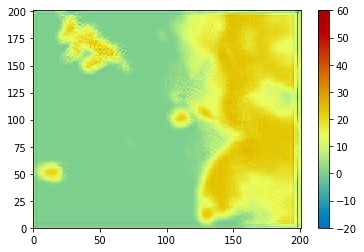

In [11]:
plt.pcolormesh(y_model[70,:,:,0]*80-20, vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
plt.colorbar()

In [388]:
output_png_path_model = '/home/rjackson/various_notebooks/deep_learning_quicklooks/model-100epochs-1frame'
if not os.path.exists(output_png_path_model):
    os.makedirs(output_png_path_model)
y_model = model_predict100[0]    
for i in range(0, y_model.shape[0]):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    im = ax.imshow(y_model[i,:,:,0]*80-20, vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
    ax.set_title('Time step ' + str(i))
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    plt.colorbar(im, label='Reflectivity [dBZ]')
    fig.savefig(output_png_path_model + '/' + str(i) + '.png', dpi=300)
    plt.close(fig)

In [129]:
output_png_path_observations = '/home/rjackson/various_notebooks/deep_learning_quicklooks/observations'
model_predict10
for j in range(120):
    y_valid = y_validation_out[j]
    my_data = y_valid*80-20
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    im = ax.imshow(my_data, vmin=-20, vmax=60, cmap='pyart_HomeyerRainbow')
    ax.set_title('Time step ' + str(j))
    plt.colorbar(im, label='Reflectivity [dBZ]')
    fig.savefig(output_png_path_observations + '/' + str(j) + '.png', dpi=300)
    plt.close(fig)

IndexError: index 3 is out of bounds for axis 0 with size 2

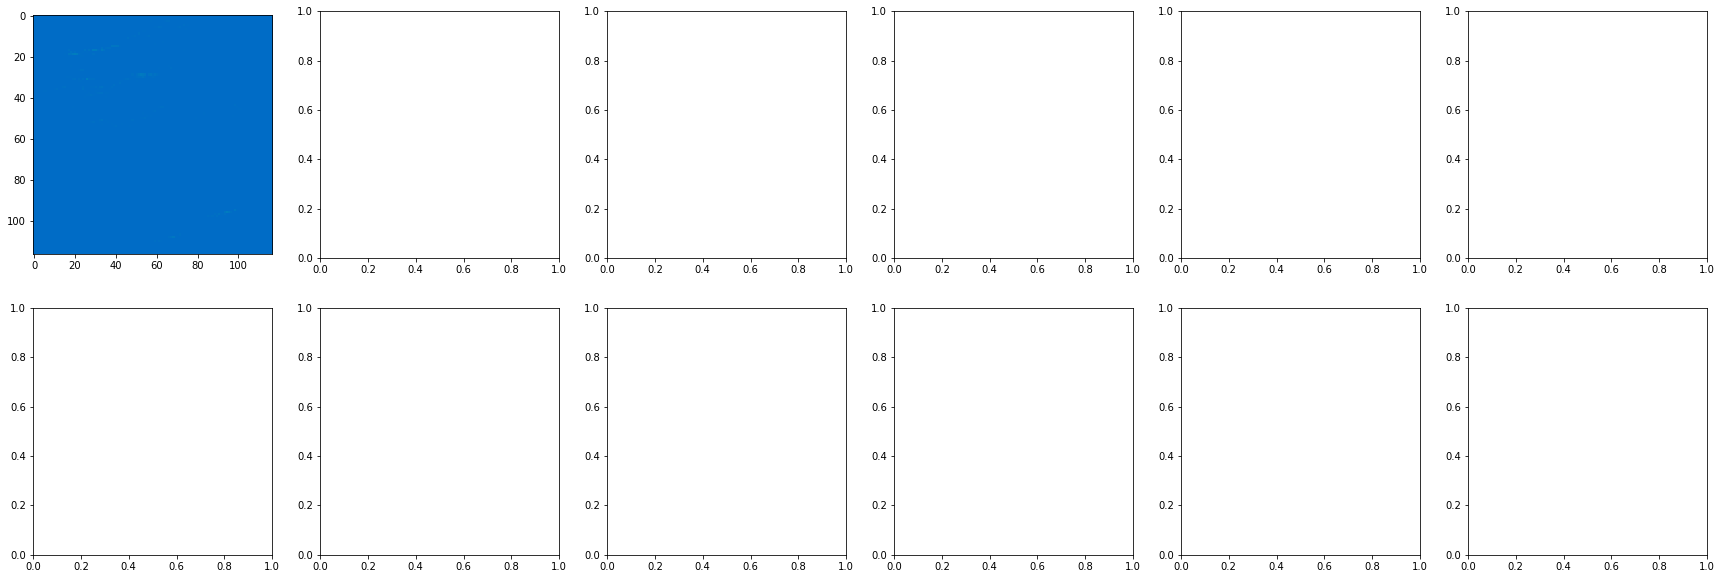

In [30]:
fig, ax = plt.subplots(2,6, figsize=(30,10))
imin = 20
imax = 30
for i in range(imin, imax):
    the_plot = ax[(i-imin)//6,(i-imin)%6].imshow(y_model[i,:,:,0], vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
    plt.colorbar(the_plot, ax=ax[i//6,i%6], label='Reflectivity [% of maximum]')
    plt.title('Predicted reflectivity (normalized)')

In [ ]:
fig, ax = plt.subplots(2,6, figsize=(30,10))
my_data = y_validation[1]
imin = 20
imax = 30
for i in range(imin, imax):
    my_img = np.squeeze(my_data[i])
    the_plot = ax[(i-imin)//6,(i-imin)%6].imshow(my_img/my_img.max(), vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
    plt.colorbar(the_plot, ax=ax[(i-imin)//6,(i-imin)%6], label='Reflectivity [% of maximum]')

In [ ]:
plt.pcolormesh(y_model[3, :,:,0], vmin=0, vmax=0.2, cmap='pyart_HomeyerRainbow')

In [ ]:
y_validation = validation_data[1]

In [ ]:
plt.pcolormesh(np.squeeze(y[1]))

In [19]:
y_validation.shape

(30, 30, 201, 201)

[[[0.30224738]
  [0.30204976]
  [0.30197194]
  ...
  [0.30186826]
  [0.30222625]
  [0.3018177 ]]

 [[0.3023277 ]
  [0.30232745]
  [0.30191162]
  ...
  [0.30197167]
  [0.3024153 ]
  [0.30191702]]

 [[0.30243438]
  [0.30203748]
  [0.3021364 ]
  ...
  [0.3017946 ]
  [0.30221725]
  [0.30164525]]

 ...

 [[0.30224538]
  [0.30231923]
  [0.3019299 ]
  ...
  [0.3018487 ]
  [0.30209437]
  [0.30170774]]

 [[0.30225945]
  [0.3023448 ]
  [0.30217144]
  ...
  [0.30206907]
  [0.302181  ]
  [0.30179176]]

 [[0.30216563]
  [0.30214852]
  [0.30186272]
  ...
  [0.30175462]
  [0.30179688]
  [0.30167186]]]


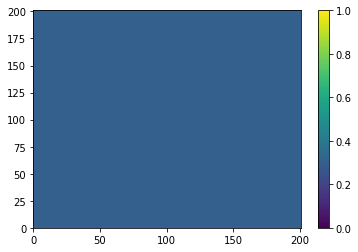

In [312]:
plt.pcolormesh(np.squeeze(y_model[30]), vmin=0, vmax=1)
plt.colorbar()
print(y_model[30])

AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

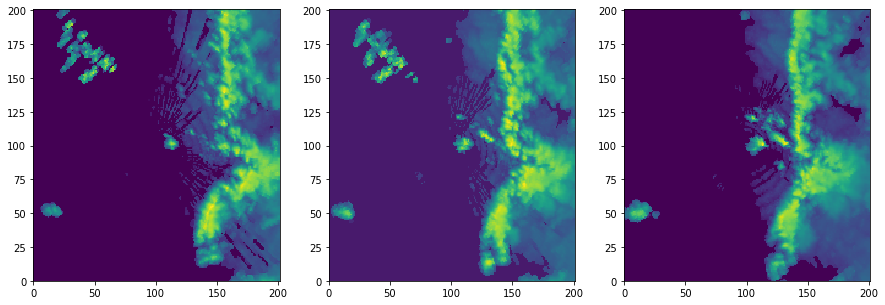

In [307]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].pcolormesh(np.squeeze(y_validation[71,0]))
ax[1].pcolormesh(np.squeeze(y_validation[71,1]))
ax[2].pcolormesh(np.squeeze(y_validation[71,2]))
ax[2].colorbar()
print(y_validation_out[30].min())

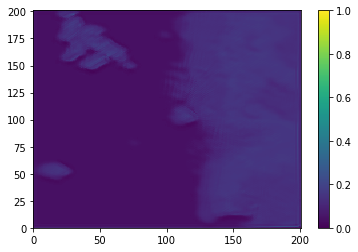

In [25]:
plt.pcolormesh(np.squeeze(y_model[70]), vmin=0, vmax=1)
plt.colorbar()

In [370]:
## RMSE evaluation
def get_model(num_frames, epoch):
    print("/home/rjackson/DNNmodel/model-%dframes-%03d.hdf5" % (num_frames, epoch))
    return load_model("/home/rjackson/DNNmodel/model-%dframes-%03d.hdf5" % (num_frames, epoch))

In [373]:
epochs = np.arange(10, 100, 10.)
model_predict10 = []
model_predict20 = []
model_predict50 = []
model_predict100 = []
for num_frames in range(1, 7):
    my_model = get_model(num_frames, 10)
    model_predict10.append(my_model.predict(input_fn_validation(num_frames), steps=7))
    my_model = get_model(num_frames, 20)
    model_predict20.append(my_model.predict(input_fn_validation(num_frames), steps=7))
    my_model = get_model(num_frames, 50)
    model_predict50.append(my_model.predict(input_fn_validation(num_frames), steps=7))
    my_model = get_model(num_frames, 100)
    model_predict100.append(my_model.predict(input_fn_validation(num_frames), steps=7))

/home/rjackson/DNNmodel/model-1frames-010.hdf5
/home/rjackson/DNNmodel/model-1frames-020.hdf5
/home/rjackson/DNNmodel/model-1frames-050.hdf5
/home/rjackson/DNNmodel/model-1frames-100.hdf5
/home/rjackson/DNNmodel/model-2frames-010.hdf5
/home/rjackson/DNNmodel/model-2frames-020.hdf5
/home/rjackson/DNNmodel/model-2frames-050.hdf5
/home/rjackson/DNNmodel/model-2frames-100.hdf5
/home/rjackson/DNNmodel/model-3frames-010.hdf5
/home/rjackson/DNNmodel/model-3frames-020.hdf5
/home/rjackson/DNNmodel/model-3frames-050.hdf5
/home/rjackson/DNNmodel/model-3frames-100.hdf5
/home/rjackson/DNNmodel/model-4frames-010.hdf5
/home/rjackson/DNNmodel/model-4frames-020.hdf5
/home/rjackson/DNNmodel/model-4frames-050.hdf5
/home/rjackson/DNNmodel/model-4frames-100.hdf5
/home/rjackson/DNNmodel/model-5frames-010.hdf5
/home/rjackson/DNNmodel/model-5frames-020.hdf5
/home/rjackson/DNNmodel/model-5frames-050.hdf5
/home/rjackson/DNNmodel/model-5frames-100.hdf5
/home/rjackson/DNNmodel/model-6frames-010.hdf5
/home/rjackso

In [377]:
validation = []
for num_frames in range(1, 7):
    validation.append(np.stack([x[1]["conv2d"]["image_raw"].numpy() for x in input_fn_validation(num_frames).take(7)]))

In [375]:
def rmse(actual, expected):
    return np.sqrt(np.sum((actual - expected)**2/(np.prod(actual.shape))))

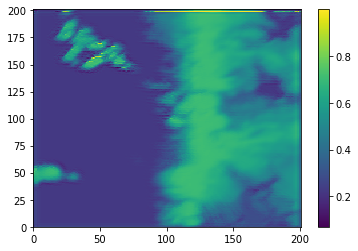

In [68]:
plt.pcolormesh(np.squeeze(model_predict10[0][75]))
plt.colorbar()

In [378]:
rmses10 = np.zeros(6)
rmses20 = np.zeros(6)
rmses50 = np.zeros(6)
rmses100 = np.zeros(6)

for i in range(6):
    rmses10[i] = rmse(model_predict10[i], np.reshape(validation[i], (210, 201, 201, 1)))
    rmses20[i] = rmse(model_predict20[i], np.reshape(validation[i], (210, 201, 201, 1)))
    rmses50[i] = rmse(model_predict50[i], np.reshape(validation[i], (210, 201, 201, 1)))
    rmses100[i] = rmse(model_predict100[i], np.reshape(validation[i], (210, 201, 201, 1)))

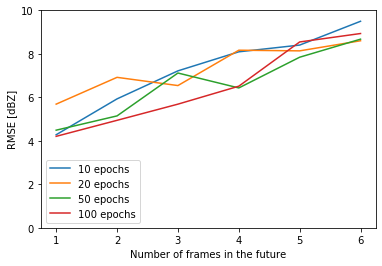

In [384]:
plt.plot(np.arange(1, 7), rmses10*80, label='10 epochs')
plt.plot(np.arange(1, 7), rmses20*80, label='20 epochs')
plt.plot(np.arange(1, 7), rmses50*80, label='50 epochs')
plt.plot(np.arange(1, 7), rmses100*80, label='100 epochs')
plt.ylabel('RMSE [dBZ]')
plt.xlabel('Number of frames in the future')
plt.ylim([0, 10])
plt.legend()
plt.savefig('RMSE_vs_epochs.png', dpi=300)